In [1]:
import torch
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import sys
import matplotlib.pyplot as plt

from tqdm.auto import trange
from copy import deepcopy
from itertools import cycle

from torchinterp1d import Interp1d

sys.path.append("../lib")

from nf.NF_base import *
from nf.realnvp import *
from swgf_mynf import SWGF as swgf_nf
from swgf_mlp import SWGF as swgf_mlp
from sw import *
from nf.utils_nf import log_likelihood
from utils_imgs.utils import uniform_quantization, rescale_logit, inverse_logit, val_mnist, val_mnist_ae
from networks.autoencoder import *
from swgf_cnn import SWGFCNN

from fid_score import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Without Autoencoder

### Utils - MNIST

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

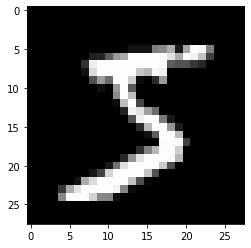

In [4]:
plt.imshow(inverse_logit(train_dataset[0][0]).reshape(28,28),"gray")
plt.show()

In [5]:
rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

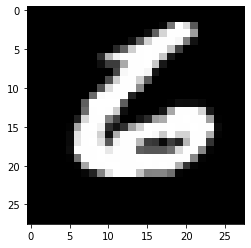

In [6]:
real_cpu = torch.zeros((10000,28,28))

cpt = 0
for data, _ in test_loader:
    real_cpu[cpt:cpt+32] = inverse_logit(data[:,0])
    cpt += 32

plt.imshow(real_cpu[-1],"gray")
plt.show()

### Gradient Flow Ambient Space

#### With RealNVP

- In data logit space

In [ ]:
def create_RealNVP_BatchNorm(nh=1024, nl=5, d=784):
    shiftings = [shifting(d//2,nh,d//2,1) for k in range(nl)]
    scalings = [scaling(d//2,nh,d//2,1) for k in range(nl)]

    flows = []
    for i in range(nl):
        flows.append(AffineCoupling(scalings[i],shiftings[i],d))
        flows.append(Reverse(d))
        flows.append(BatchNorm(d))

    model = NormalizingFlows(flows).to(device)
    return model

In [7]:
def J(x, z, log_det):
    batch_size = x.size(0)
    target = next(dataiter)[0].reshape(-1,28*28).to(device)
    
    sw = sliced_wasserstein(x, target, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    h = torch.mean(log_likelihood(z, log_det, device),axis=0) ## entropy
    return sw/2

In [8]:
t_init = 0
t_end = 100
h = 5

n_steps = int(np.ceil((t_end-t_init)/h))

d = 784

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

lrs = 1e-2 * np.ones(n_steps)
lrs[0] = 1e-2

n_epochs = 500 * np.ones(n_steps)
n_epochs[0] = 1500
n_epochs[1] = 1000

Lrho = swgf_nf(rho_0, h, n_step=n_steps, n_epochs=n_epochs, d=d,
               J=J, create_NF=create_RealNVP_BatchNorm, nh=1024, nl=5, lrs=lrs, 
               num_projections=1000, n_samples=1000, plot_loss=False, tqdm_bar=True)

  0%|          | 0/1 [00:00<?, ?it/s]

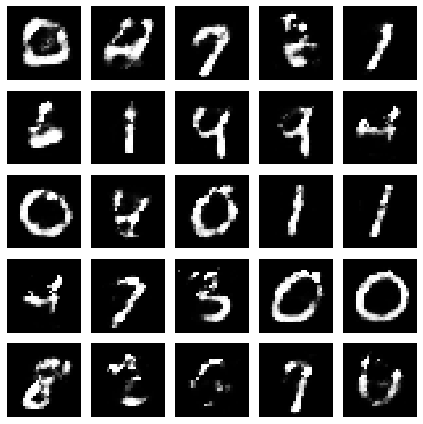

In [24]:
val_mnist(Lrho[-1], device)

1 5


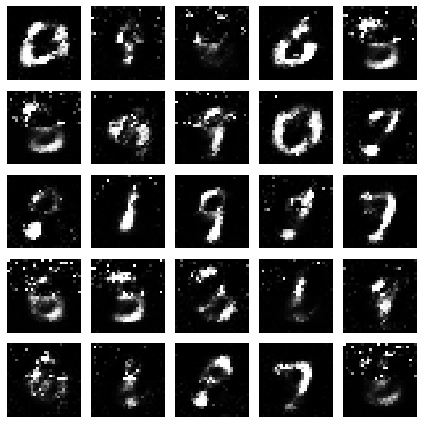

2 10


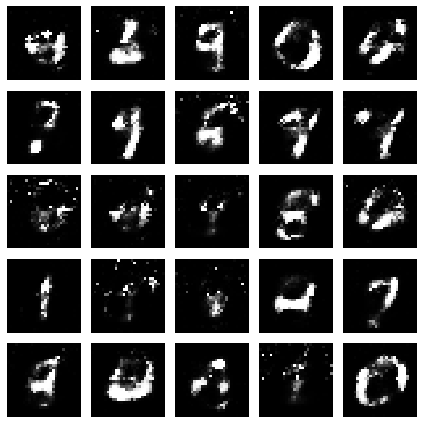

3 15


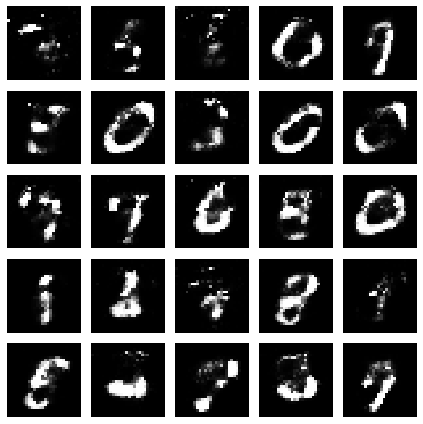

4 20


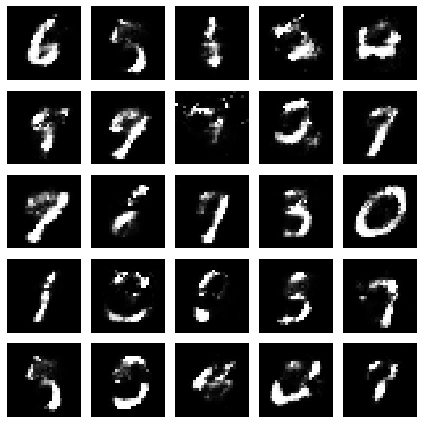

5 25


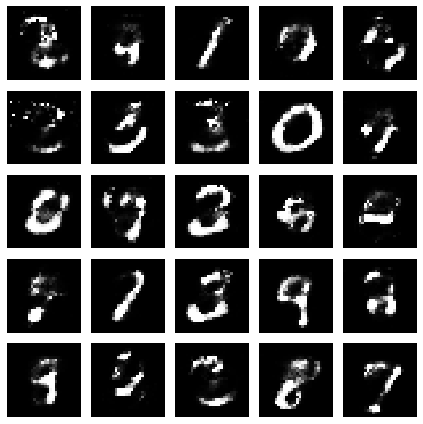

6 30


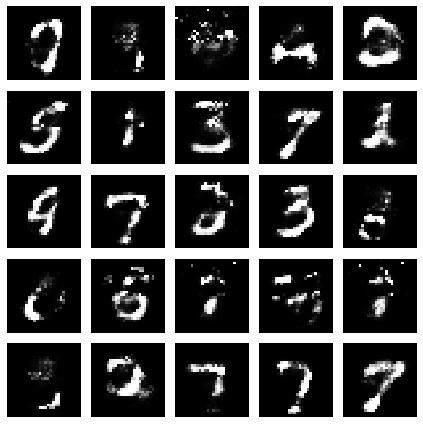

7 35


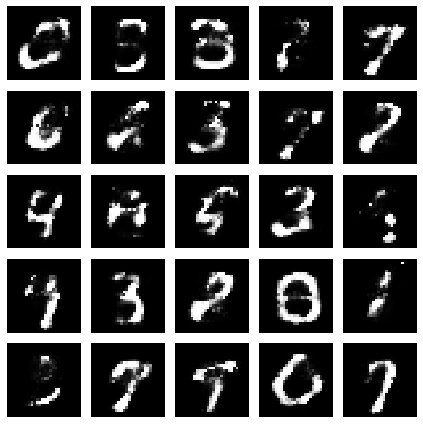

8 40


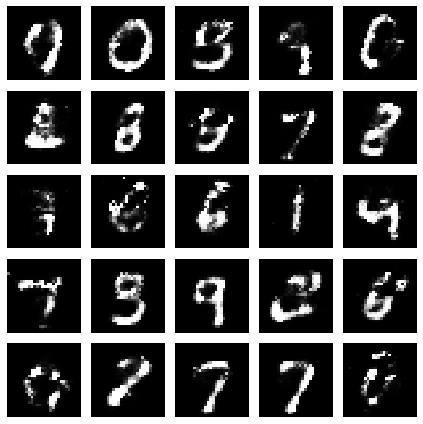

9 45


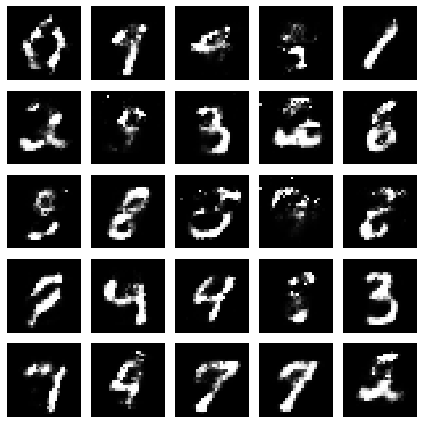

10 50


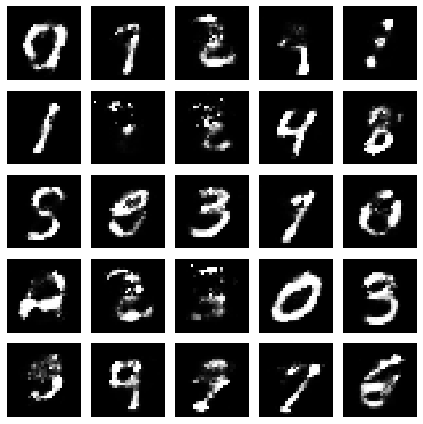

11 55


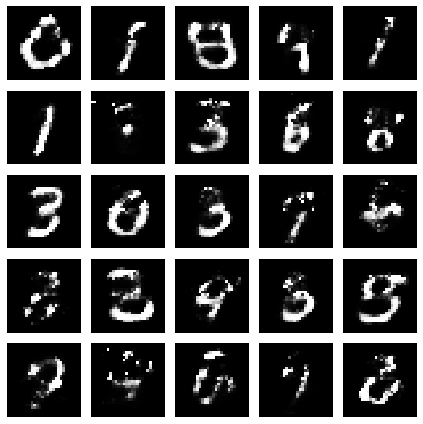

12 60


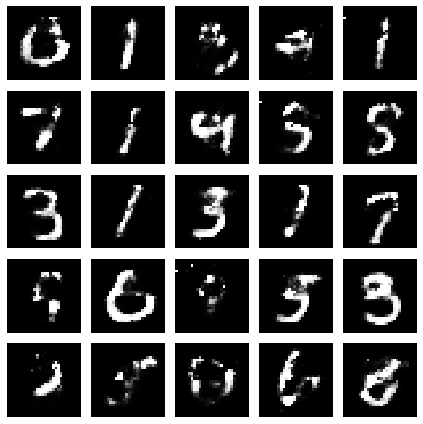

13 65


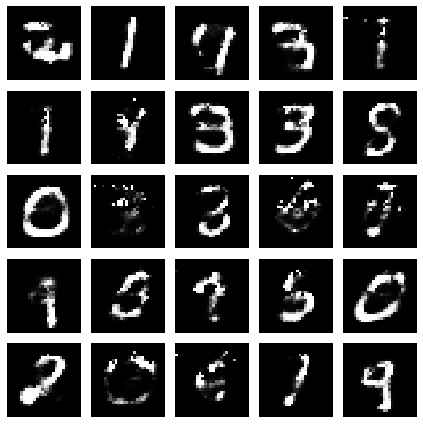

14 70


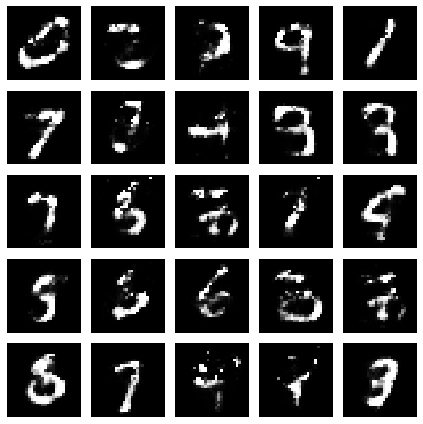

15 75


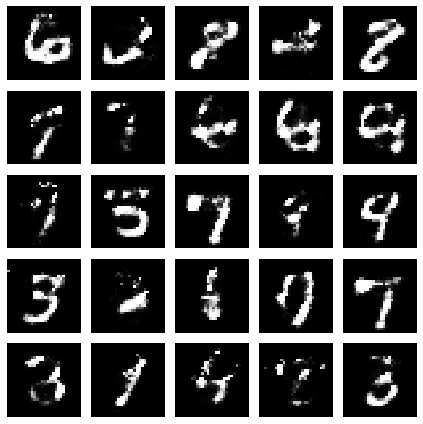

16 80


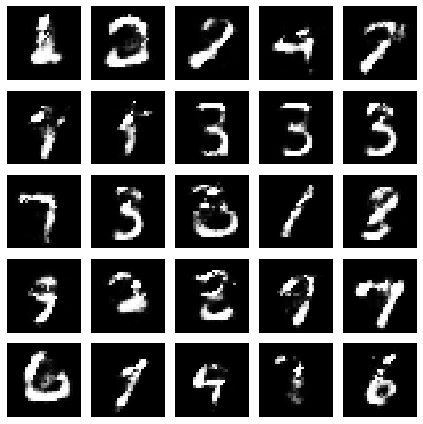

17 85


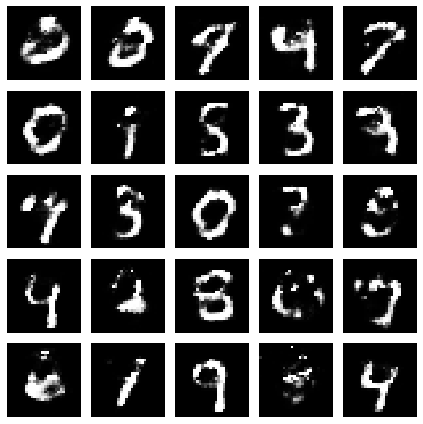

18 90


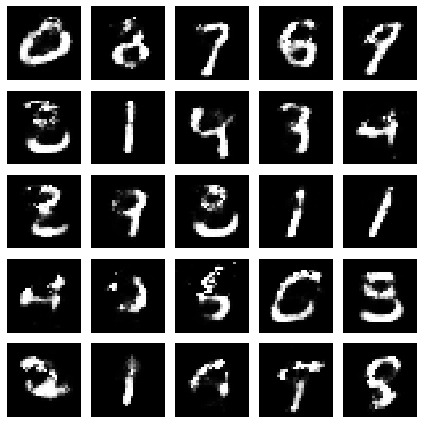

19 95


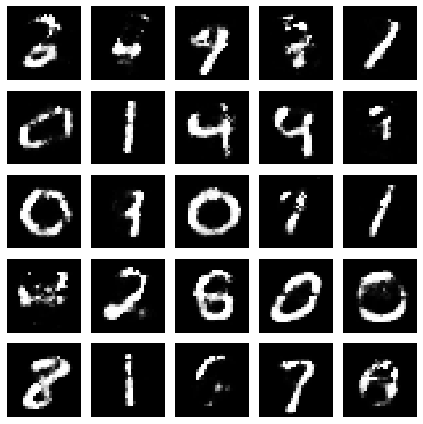

20 100


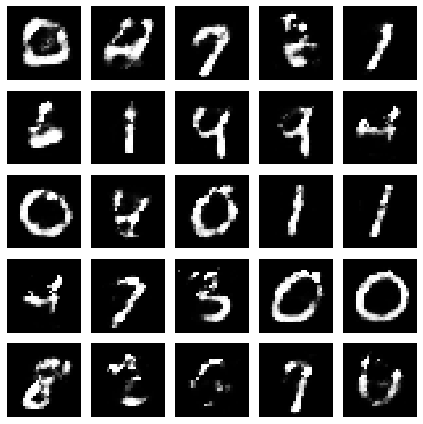

In [25]:
for k in range(1,len(Lrho)):
    print(k,k*h)
    val_mnist(Lrho[k], device)

In [26]:
z = torch.randn(10000, 28*28, device=device)
zs, _ = Lrho[-1](z)
gen_imgs = inverse_logit(zs[-1].reshape(-1,28,28,1).detach().cpu())

In [27]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

88.09428619392867

#### With MLP

In [10]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

In [11]:
rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

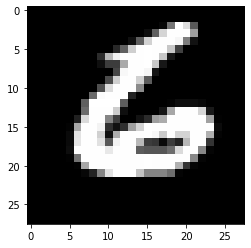

In [12]:
real_cpu = torch.zeros((10000,28,28))

cpt = 0
for data, _ in test_loader:
    real_cpu[cpt:cpt+32] = data[:,0]
    cpt += 32

plt.imshow(real_cpu[-1],"gray")
plt.show()

In [13]:
class mlp(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

In [14]:
def J(rho):
    z = torch.randn(128, 28*28, device=device)
    x = rho(z)
    
    target = next(dataiter)[0].reshape(-1,28*28).to(device)
    
    sw = sliced_wasserstein(x, target, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    return sw/2

In [15]:
t_init = 0
t_end = 100
h = 5

n_steps = int(np.ceil((t_end-t_init)/h))

d = 784

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

lrs = 1e-3 * np.ones(n_steps)
lrs[0] = 5e-3

n_epochs = 500 * np.ones(n_steps)
n_epochs[0] = 1000
# n_epochs[1] = 1000

Lrho = swgf_mlp(rho_0, h, n_step=n_steps, n_epochs=n_epochs, d=d,
                J=J, create_nn=mlp, nh=512, nl=5, lrs=lrs, 
                num_projections=1000, n_samples=1000, plot_loss=False, tqdm_bar=True)

  0%|          | 0/20 [00:00<?, ?it/s]

mlp


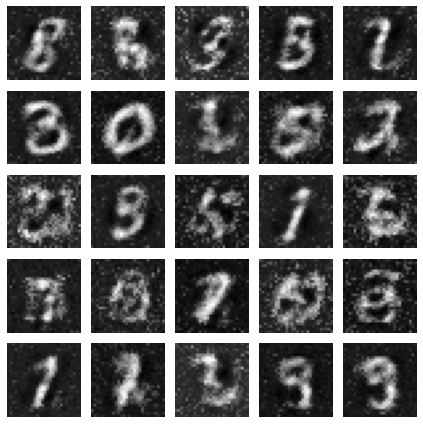

In [16]:
val_mnist(Lrho[-1], device)

In [18]:
z = torch.randn(10000, 28*28, device=device)
zs = Lrho[-1](z)
gen_imgs = inverse_logit(zs.reshape(-1,28,28,1).detach().cpu())

In [19]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

231.99297046011415

#### With CNN

In [3]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

In [4]:
rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

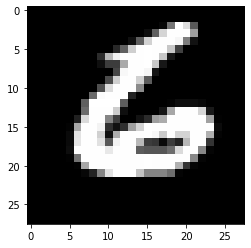

In [5]:
real_cpu = torch.zeros((10000,28,28))

cpt = 0
for data, _ in test_loader:
    real_cpu[cpt:cpt+32] = data[:,0]
    cpt += 32

plt.imshow(real_cpu[-1],"gray")
plt.show()

In [6]:
def J(rho):
    z = torch.randn(128, 100, 1, 1, device=device)
    x = rho(z)
    
    target = next(dataiter)[0].reshape(-1,28*28).to(device)
    
    sw = sliced_wasserstein(x.reshape(-1,28*28), target, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    return sw/2

In [7]:
t_init = 0
t_end = 100
h = 5

n_steps = int(np.ceil((t_end-t_init)/h))

d = 784

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

lrs = 1e-3

n_epochs = 500 * np.ones(n_steps)
n_epochs[0] = 1000
# n_epochs[1] = 1000

Lrho = SWGFCNN(rho_0, h, n_step=n_steps, n_epochs=n_epochs, d=d,
               J=J, lrs=lrs, num_projections=1000, 
               n_samples=1000, plot_loss=False, tqdm_bar=True)

  0%|          | 0/20 [00:00<?, ?it/s]

/share/home/bonet/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


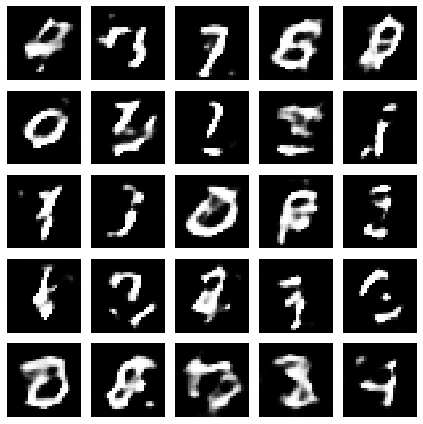

In [10]:
val_mnist(Lrho[-1], device)

In [11]:
z = torch.randn(10000, 100, 1, 1, device=device)
zs = Lrho[-1](z)
# gen_imgs = inverse_logit(zs.reshape(-1,28,28,1).detach().cpu())
gen_imgs = zs.reshape(-1,28,28,1).detach().cpu()

In [15]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

69.3335268253407

## With Autoencoder

### Utils Mnist

In [7]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(28)
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

rand_sampler = torch.utils.data.RandomSampler(train_dataset) #, replacement=True)
train_sampler = torch.utils.data.DataLoader(train_dataset, batch_size=128, sampler=rand_sampler)
dataiter = iter(cycle(train_sampler))

In [8]:
real_cpu = torch.zeros((10000,28,28))

cpt = 0
for data, _ in test_loader:
    real_cpu[cpt:cpt+32] = data[:,0]
    cpt += 32

# plt.imshow(real_cpu[-1],"gray")
# plt.show()

### Autoencoder

In [9]:
criterion = nn.BCELoss(reduction='sum')

def ae_loss(x, y):
    reconstruction_loss = criterion(y, x)    
    return reconstruction_loss

In [10]:
model = AE(train_loader.dataset[0][0].shape, 48).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

  0%|          | 0/11 [00:00<?, ?it/s]

0 149.2332035327686 81.86515922668262


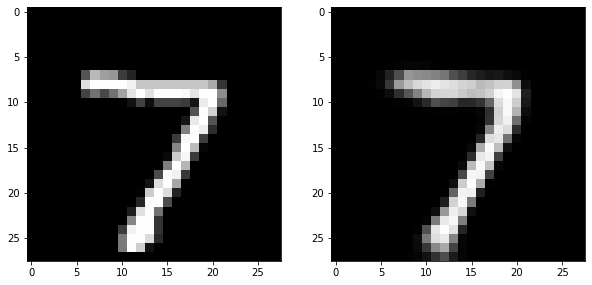

1 76.66037515451829 72.74179051554621
2 71.45515618666573 69.44395639340337
3 68.98053930969888 67.29685264806778
4 67.45683728606463 66.0854972254354
5 66.2520736743138 65.50071144713381


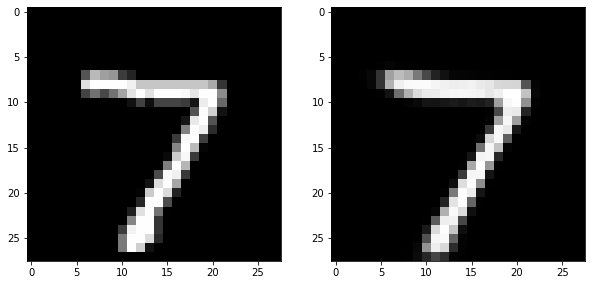

6 65.39717840589186 64.85468221548648
7 64.69498467191195 63.75718614620904
8 64.07245740097468 63.50000162094165
9 63.648410916413155 63.18582819978269
10 63.17419467212972 63.08090725493507


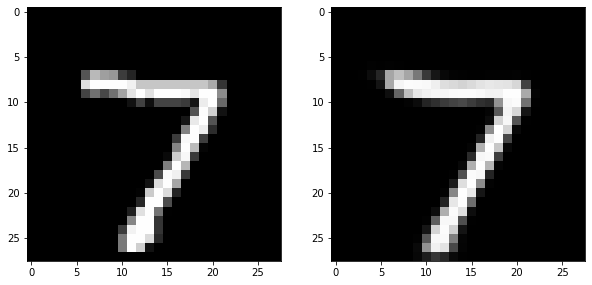

In [11]:
n_epochs = 11

pbar = trange(n_epochs)

losses = []
val_losses = []

for e in pbar:
    loss_epoch = 0
    cpt_batch = 0
    
    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        
        model.train()
        
        y_hat = model(x_batch)
        l = ae_loss(x_batch, y_hat)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_epoch += l.item()/x_batch.size(0)
        cpt_batch += 1

    losses.append(loss_epoch/cpt_batch)
    
    loss_val_epoch = 0
    cpt_batch = 0
        
    with torch.no_grad():
        for x_val, _ in test_loader:
            x_val = x_val.to(device)
            
            model.eval()
            yhat = model(x_val)            
            val_l = ae_loss(x_val,yhat)
            loss_val_epoch += val_l.item()/x_val.size(0)
            cpt_batch += 1
            
        val_losses.append(loss_val_epoch/cpt_batch)

    print(e,losses[-1],val_losses[-1])
        
    if e%5 == 0:  
        for x_val, _ in test_loader:
            fig,ax = plt.subplots(1,2,figsize=(10,10))

            ax[0].imshow(x_val[0][0],"gray")

            x_val = x_val.to(device)

            model.eval()
            yhat = model(x_val[0][0].reshape(-1,28,28))
            yhat = yhat.reshape(-1,1,28,28)
            ax[1].imshow(yhat[0][0].cpu().detach().numpy(),"gray")
            plt.show()
            break
        
        
        

In [12]:
train_cpu = torch.zeros((10000,28,28))

cpt = 0
for data, _ in train_loader:
    if cpt+128>10000:
#         print(cpt+128)
        train_cpu[cpt:] = data[:16,0]
    else:
        train_cpu[cpt:cpt+128] = data[:,0]
    cpt += 128
    
    if cpt>10000:
        break

In [13]:
gen_imgs = model(train_cpu.to(device).reshape(-1,1,28,28)).detach().cpu().reshape(-1,28,28,1)

evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

15.557004800138941

### Gradient Flow

In [17]:
def create_RealNVP(nh, nl, d):
    shiftings = [shifting(d//2,nh,d//2,2) for k in range(nl)]
    scalings = [scaling(d//2,nh,d//2,2) for k in range(nl)]

    flows = []
    for i in range(nl):
        flows.append(AffineCoupling(scalings[i],shiftings[i],d))
        flows.append(Reverse(d))
        flows.append(BatchNorm(d))

    model = NormalizingFlows(flows).to(device)
    return model

#### Without Entropy

In [18]:
def J(x, z, log_det):
    target = next(dataiter)[0].to(device)
    target_encoded = model.encoder(target)
    
    sw = sliced_wasserstein(x, target_encoded, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    return sw/2

In [19]:
t_init = 0
t_end = 50
h = 5

n_steps = int(np.ceil((t_end-t_init)/h))

d = 48

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

lrs = 5e-3 * np.ones(n_steps)
lrs[0] = 1e-2

n_epochs = 1000 * np.ones(n_steps)
n_epochs[0] = 3000
n_epochs[1] = 2000

Lrho = swgf_nf(rho_0, h, n_step=n_steps, n_epochs=n_epochs.astype(int), d=d,
               J=J, create_NF=create_RealNVP, nh=100, nl=5, lrs=lrs, 
               num_projections=1000, n_samples=1024, plot_loss=False, tqdm_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

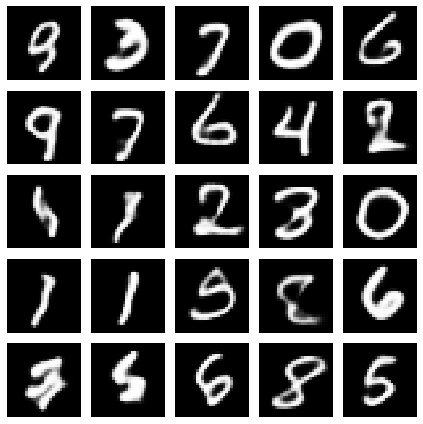

In [15]:
val_mnist_ae(Lrho[-1], model, device)

In [16]:
z = torch.randn(10000, 48, device=device)
zs, _ = Lrho[-1](z.reshape(-1,48))
gen_imgs = model.decoder(zs[-1]).detach().cpu().reshape(-1,28,28,1)

In [17]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

17.829551106097625

#### With entropy

In [60]:
def J(x, z, log_det):
    target = next(dataiter)[0].to(device)
    target_encoded = model.encoder(target)
    
    sw = sliced_wasserstein(x, target_encoded, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2)
    
    h = torch.mean(log_likelihood(z, log_det, device),axis=0) ## entropy

    return sw/2+1e-4 * h

In [61]:
t_init = 0
t_end = 50
h = 5

n_steps = int(np.ceil((t_end-t_init)/h))

d = 48

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

lrs = 5e-3 * np.ones(n_steps)
lrs[0] = 1e-2

n_epochs = 1000 * np.ones(n_steps)
n_epochs[0] = 3000
n_epochs[1] = 2000

Lrho = swgf_nf(rho_0, h, n_step=n_steps, n_epochs=n_epochs, d=d,
               J=J, create_NF=create_RealNVP, nh=1024, nl=1, lrs=lrs, 
               num_projections=1000, n_samples=1024, plot_loss=False, tqdm_bar=True)

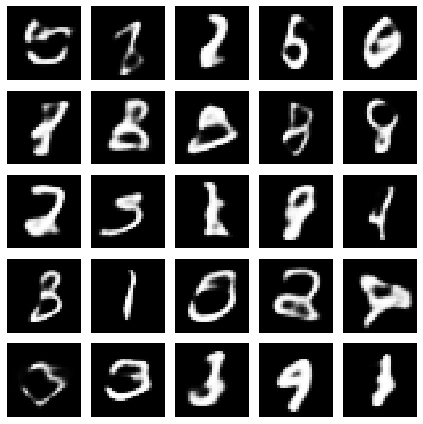

In [63]:
val_mnist_ae(Lrho[-1], model, device)

In [64]:
z = torch.randn(10000, 48, device=device)
zs, _ = Lrho[-1](z.reshape(-1,48))
gen_imgs = model.decoder(zs[-1]).detach().cpu().reshape(-1,28,28,1)

In [65]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

24.209153297954543

#### With MLP

In [23]:
class mlp(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

In [24]:
def J(rho):    
    target = next(dataiter)[0].to(device)
    target_encoded = model.encoder(target)
    
    z = torch.randn(target.size(0), target_encoded.size(1), device=device)
    x = rho(z)
    
    sw = sliced_wasserstein(x, target_encoded, num_projections=1000, device=device, 
                           u_weights=None, v_weights=None, p=2) 
    return sw/2

In [25]:
t_init = 0
t_end = 100
h = 5

n_steps = int(np.ceil((t_end-t_init)/h))

d = 48

mu0 = torch.zeros(d, device=device, dtype=torch.float)
sigma0 = torch.eye(d, device=device, dtype=torch.float)
rho_0 = D.MultivariateNormal(mu0,sigma0)

lrs = 1e-3 * np.ones(n_steps)
lrs[0] = 5e-3

n_epochs = 1000 * np.ones(n_steps)
n_epochs[0] = 3000
n_epochs[1] = 2000

Lrho = swgf_mlp(rho_0, h, n_step=n_steps, n_epochs=n_epochs, d=d,
                J=J, create_nn=mlp, nh=512, nl=5, lrs=lrs, 
                num_projections=1000, n_samples=1000, plot_loss=False, tqdm_bar=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [36]:
z = torch.randn(10000, 48, device=device)
zs = Lrho[-1](z.reshape(-1,48))
gen_imgs = model.decoder(zs).detach().cpu().reshape(-1,28,28,1)

In [37]:
evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

18.373881685774364

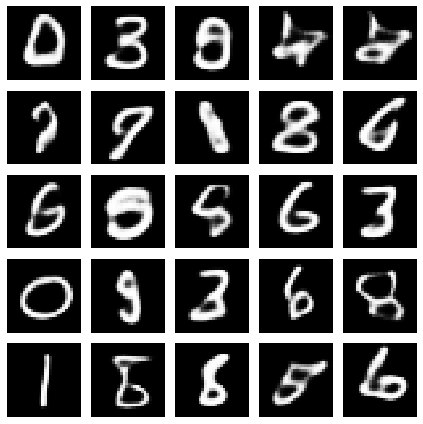

In [30]:
val_mnist_ae(Lrho[-1], model, device)

#### SWF

In [38]:
def swf(n, d, n_epochs, dataiter, autoencoder, device=device, 
        tauk=1e-1, n_projs=50, reg=1e-4, plot=False):
    
    x0 = torch.randn(n, d, device=device)
    L = [x0.cpu().clone()]
    
    xk = x0.clone()

    percentiles = torch.linspace(0,1,100,device=device)

    pbar = trange(n_epochs)
    for k in pbar:

        if plot and k%100==0:
            print("Iteration " + str(k))
            gen_imgs = torch.zeros((10000,28,28))

            for i in range(10):
                imgs = autoencoder.decoder(xk[i*1000:(i+1)*1000].to(device)).detach().cpu().reshape(-1,28,28)
                gen_imgs[i*1000:(i+1)*1000] = imgs
                
            r, c = 5, 5
            cpt = 0
            fig,ax = plt.subplots(r,c)
            for i in range(r):
                for j in range(c):
                    ax[i,j].imshow(gen_imgs[cpt], "gray")
                    ax[i,j].axis("off")
                    cpt += 1

            fig.set_size_inches(6, 6)
            plt.tight_layout()
            plt.show()


        theta = torch.randn(n_projs, d)
        theta = F.normalize(theta, p=2, dim=1).to(device)

        target = autoencoder.encoder(next(dataiter)[0].to(device)).detach()

        target_proj = (target@theta.T).T
        xk_proj = (xk@theta.T).T
        torch.sort(target_proj, -1)
        torch.sort(xk_proj, -1)

        xk_quantiles = torch.tensor(np.percentile(xk_proj.cpu(), percentiles.cpu()*100, axis=1), 
                                    device=device, dtype=torch.float32).T
        cdf_xk = Interp1d()(xk_quantiles, percentiles, xk_proj).detach()
        
        target_quantiles = torch.tensor(np.percentile(target_proj.cpu(), percentiles.cpu()*100, axis=1), 
                                        device=device, dtype=torch.float).T
        q = Interp1d()(percentiles.repeat(n_projs,1), target_quantiles, cdf_xk).detach()

        nabla = ((xk_proj-q)[:,None,:]*theta[:,:,None]).mean(dim=0).T

        zk = torch.randn(xk.size(), device=device)
        xk = xk - tauk * nabla + np.sqrt(2*tauk*reg) * zk
        L.append(xk.cpu().clone())
    
    return L

In [42]:
L = swf(10000, 48, 1000, dataiter, autoencoder=model, tauk=1, n_projs=1000, reg=0, plot=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [43]:
xk = L[-1]
gen_imgs = model.decoder(xk.to(device)).detach().cpu().reshape(-1,28,28,1)

evaluate_fid_score(real_cpu.reshape(-1,28,28,1), gen_imgs, batch_size=50)

22.543703048146256